# 1) Utilize a random 80-20 split of the original dataset in term of training, testing ratio

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML

# Function display data frames side by side
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side 
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))
    
# Read training data (the first 30% of the initial data) as dataframe
msr_paraphrase_train = pd.read_csv("msr_paraphrase_train.txt", delimiter="\t", quoting = 3)
msr_paraphrase_train[["#1 String", "#2 String"]] = msr_paraphrase_train[["#1 String", "#2 String"]].astype('str')

# Read testing data (the last 70%) as dataframe
msr_paraphrase_test = pd.read_csv("msr_paraphrase_test.txt", delimiter="\t", quoting = 3)
msr_paraphrase_test[["#1 String", "#2 String"]] = msr_paraphrase_test[["#1 String", "#2 String"]].astype('str')

# Combine training data and testing data to return it into original data
msrp_data = pd.concat([msr_paraphrase_train, msr_paraphrase_test], ignore_index=True)

#Split the original data set under training and testing data at the ratio of 80-20
X = msrp_data
y = X["Quality"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display some rows of training data and testing data
display_side_by_side([X_train.head(5), X_test.head(5)], ['Training MRPC Data', 'Testing MRPC Data'])

,Quality,#1 ID,#2 ID,#1 String,#2 String
3265,0,2760410,2760324,"Excluding the impact of accounting changes, Ford would have earned 13 cents a share.","Excluding the $56 million charge and the accounting change, Ford's third-quarter earnings amounted to 15 cents a share."
2859,1,698940,698952,"Martha Stewart shares fell $2.03, about 18 percent, to $9.17 and were the NYSE's biggest percentage loser.","Its shares fell 4.6 percent, or $4.04, to $83.38 and was the blue-chip Dow's biggest percent loser."
4692,1,2706235,2706274,"Jail warden Gene Fischi said said Selenski and Bolton broke their 12-inch-by-18-inch cell window, threw a mattress to the ground and shimmied down the rope to a second-story roof.","Warden Gene Fischi said the two inmates broke a 12-by-18-inch cell window, threw a mattress to the ground, and clambered down the makeshift rope to a second-story roof."
5694,1,364462,364510,U.S. prosecutors have arrested more than 130 individuals and have seized more than $17 million in a continuing crackdown on Internet fraud and abuse.,More than 130 people have been arrested and $17 million worth of property seized in an Internet fraud sweep announced Friday by three U.S. government agencies.
3105,1,327456,327366,Economists said that raised the odds of a rate cut at the Fed's next meeting on June 24-25.,Economists said those concerns raised the odds that the Fed might reduce rates at its next meeting on June 24-25.
,Quality,#1 ID,#2 ID,#1 String,#2 String
3737,1,1621176,1621114,It is publishing the studies in the July issue of its Journal of Allergy and Clinical Immunology.,The reports are among several published this week in the Journal of Allergy and Clinical Immunology.
1103,0,516006,515989,"Responding later, Edward Skyler, a spokesman for the mayor, said, ""The comptroller's statements, while noteworthy for their sensationalism, bear no relation to the facts.","Jordan Barowitz, a spokesman for Republican Mayor Michael Bloomberg said: ""The Comptroller's statements, while noteworthy for their sensationalism, bear no relation to the facts."""
812,0,2128530,2128455,"However, EPA officials would not confirm the 20 percent figure.",Only in the past few weeks have officials settled on the 20 percent figure.
1632,1,987465,987205,"However, George Heath, a Fort Campbell spokesman, said shortly after the attack that Akbar had ""an attitude problem"".","However, a Fort Campbell spokesman, said that Akbar had ""an attitude problem."""


# 2) Consider a pair of sentences is a paraphrase or not by using FuzzyWuzzy on training and testing data

## Calculate FuzzyWuzzy

In [2]:
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process 

def cal_fuzzy(df):
    """Calculate fuzzy score of pair sentences 
    Input:
        df: list of pandas.DataFrame
    Output:
        df with fuzzywuzzy score columns
    """
    df_score = df.astype(str)
    df_score['fuzz_score'] = df.apply(lambda row: fuzz.ratio(row['#1 String'], row['#2 String']), axis=1)
    return df_score
   
# Calculate fuzzy score    
X_train_score = cal_fuzzy(X_train)
X_test_score = cal_fuzzy(X_test)

# Display some fuzzy scores of training data and testing data
display_side_by_side([X_train_score.head(5), X_test_score.head(5)], ['Fuzzy score of training MRPC Data', 'Fuzzy score of testing MRPC Data'])

,Quality,#1 ID,#2 ID,#1 String,#2 String,fuzz_score
3265,0,2760410,2760324,"Excluding the impact of accounting changes, Ford would have earned 13 cents a share.","Excluding the $56 million charge and the accounting change, Ford's third-quarter earnings amounted to 15 cents a share.",68
2859,1,698940,698952,"Martha Stewart shares fell $2.03, about 18 percent, to $9.17 and were the NYSE's biggest percentage loser.","Its shares fell 4.6 percent, or $4.04, to $83.38 and was the blue-chip Dow's biggest percent loser.",64
4692,1,2706235,2706274,"Jail warden Gene Fischi said said Selenski and Bolton broke their 12-inch-by-18-inch cell window, threw a mattress to the ground and shimmied down the rope to a second-story roof.","Warden Gene Fischi said the two inmates broke a 12-by-18-inch cell window, threw a mattress to the ground, and clambered down the makeshift rope to a second-story roof.",80
5694,1,364462,364510,U.S. prosecutors have arrested more than 130 individuals and have seized more than $17 million in a continuing crackdown on Internet fraud and abuse.,More than 130 people have been arrested and $17 million worth of property seized in an Internet fraud sweep announced Friday by three U.S. government agencies.,49
3105,1,327456,327366,Economists said that raised the odds of a rate cut at the Fed's next meeting on June 24-25.,Economists said those concerns raised the odds that the Fed might reduce rates at its next meeting on June 24-25.,75
,Quality,#1 ID,#2 ID,#1 String,#2 String,fuzz_score
3737,1,1621176,1621114,It is publishing the studies in the July issue of its Journal of Allergy and Clinical Immunology.,The reports are among several published this week in the Journal of Allergy and Clinical Immunology.,68
1103,0,516006,515989,"Responding later, Edward Skyler, a spokesman for the mayor, said, ""The comptroller's statements, while noteworthy for their sensationalism, bear no relation to the facts.","Jordan Barowitz, a spokesman for Republican Mayor Michael Bloomberg said: ""The Comptroller's statements, while noteworthy for their sensationalism, bear no relation to the facts.""",80
812,0,2128530,2128455,"However, EPA officials would not confirm the 20 percent figure.",Only in the past few weeks have officials settled on the 20 percent figure.,62
1632,1,987465,987205,"However, George Heath, a Fort Campbell spokesman, said shortly after the attack that Akbar had ""an attitude problem"".","However, a Fort Campbell spokesman, said that Akbar had ""an attitude problem.""",79


# Estimate threshold using logistic regression, perform the testing on the testing sample and report the results in terms of accuracy score

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.optimize import fsolve
import numpy as np

# Sigmoid function
def sigmoid(s):
    return 1/(1 + np.exp(-s))

# Function to predict y
def predict(X, threshold):
    y_pred = X > threshold
    
    return y_pred.astype(int)

def pd_to_np(X_train_score, y_train, X_test_score, y_test, score_type):
    # Convert pandas data to suitable numpy
    xtrain = X_train_score[score_type].to_numpy().reshape(-1, 1)
    xtest = X_test_score[score_type].to_numpy().reshape(-1, 1)
    ytrain = y_train.to_numpy()
    ytest = y_test.to_numpy()
    
    return xtrain, xtest, ytrain, ytest
# Function estimate threshold using logistic regression.
def lr_threshold(X_train_score, y_train, X_test_score, y_test, score_type):
    model = LogisticRegression()
    
    # Convert pandas data to np
    xtrain, xtest, ytrain, ytest = pd_to_np(X_train_score, y_train, X_test_score, y_test, score_type)

    #Use the training sample to estimate the threshold 
    model.fit(xtrain, ytrain)
    
    # Probability 0.5 is chosen as the hard threshold - calculate fuzzyy score threshold
    #threshold = fsolve(lambda x: 0.5 - 1/(1 + np.exp(model.intercept_[0]+model.coef_[0]*x)), 2)
    threshold = -model.intercept_.item()/model.coef_.item()
    
    ytest_pred = predict(xtest, threshold)
    accuracy = accuracy_score(ytest, ytest_pred)
    
    return model.intercept_.item(), model.coef_.item(), ytest_pred, threshold, accuracy

# Estimate threshold, y, accuracy using logistic regression
w0_fuzz, w1_fuzz, ytest_pred_fuzz, threshold_fuzz, accuracy_fuzz = lr_threshold(X_train_score, y_train, X_test_score, y_test, 'fuzz_score')

# Perform model on the testing  data using logistic regression threshold
print('FuzzyWuzzy accuracy score on testing samples:', round(accuracy_fuzz,3),'using estimate threshold =', round(threshold_fuzz,3))

#print('Accuracy score on testing samples:', accuracy)
#print('Accuracy score on testing samples:', model.score(xtest_fuzz, ytest))

FuzzyWuzzy accuracy score on testing samples: 0.733 using estimate threshold = 61.099


## Plot data, sigmoid function and threshold have found

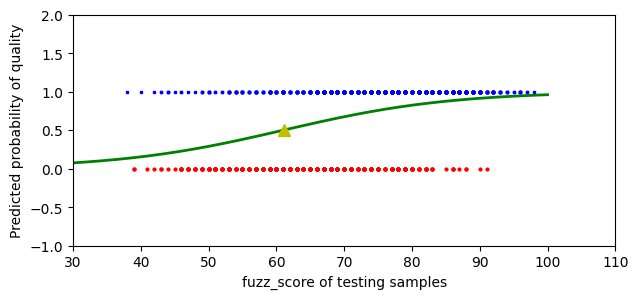

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot data, sigmoid function and threshold have found.
def plot_sig(X_test, y_test, w0, w1, score_type):


    X0 = X_test[score_type][y_test==0]
    y0 = y_test[y_test==0]
    X1 = X_test[score_type][y_test==1]
    y1 = y_test[y_test==1]

    plt.figure(figsize=(7,3))

    plt.plot(X0, y0, 'ro', markersize = 2)
    plt.plot(X1, y1, 'bs', markersize = 2)

    xx = np.linspace(0, 100, 1000)

    # Estimate the threshold 
    threshold = -w0/w1
    yy = sigmoid(w0 + w1*xx)

    plt.axis([30, 110, -1, 2])
    plt.plot(xx, yy, 'g-', linewidth = 2)
    plt.plot(threshold, .5, 'y^', markersize = 8)
    plt.xlabel(str(score_type) + ' of testing samples')
    plt.ylabel('Predicted probability of quality')
    plt.show()


plot_sig(X_test_score, y_test, w0_fuzz, w1_fuzz, 'fuzz_score')

# 3. Repeat 2) when various types of preprocessing were employed (stopwords removal, stemming, removing of abbreviations…)  

## Apply lowercase, remove punctuations and Wordnet Lemmatizer with POS tag on training, testing data

In [5]:
"""Sourcode for this task https://nlpforhackers.io/wordnet-sentence-similarity/ """
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

def pre_process(text):
    clean_data = []
    for x in (text): 
        new_text = re.sub('<.*?>', '', x)   # remove HTML tags
        new_text = re.sub(r'[^\w\s]', '', new_text) # remove punc.
        new_text = re.sub(r'\d+','',new_text)# remove numbers
        new_text = new_text.lower() # lower case        
        if new_text != '':
            clean_data.append(new_text)
    return ''.join(clean_data)

def remove_st(text):
    stop = stopwords.words('english')
    remove_text = [word for word in text.split() if word not in (stop)]
    return ' '.join(remove_text)

def lemmatize_pos_text(text):
    lemma_data = []
    lemmatizer = WordNetLemmatizer()
    lemmatize_tokens = [lemmatizer.lemmatize(w) for w in word_tokenize(text)]
    for word, tag in pos_tag(word_tokenize(text)):
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        if not wntag:
            lemma = word
        else:
            lemma = lemmatizer.lemmatize(word, wntag)
        lemma_data.append(lemma)
    return ' '.join(lemma_data)

def apply_on_data(X_train, X_test):
    X_train_prep = X_train.copy()
    X_test_prep = X_test.copy()
    
    # Training data
    X_train_prep['#1 String'] = X_train_prep['#1 String'].apply(pre_process)
    X_train_prep['#2 String'] = X_train_prep['#2 String'].apply(pre_process)
    
    X_train_prep['#1 String'] = X_train_prep['#1 String'].apply(lemmatize_pos_text)
    X_train_prep['#2 String'] = X_train_prep['#2 String'].apply(lemmatize_pos_text)
    
    X_train_prep['#1 String'] = X_train_prep['#1 String'].apply(remove_st)
    X_train_prep['#2 String'] = X_train_prep['#2 String'].apply(remove_st)
    
    # Testing data
    X_test_prep['#1 String'] = X_test_prep['#1 String'].apply(pre_process)
    X_test_prep['#2 String'] = X_test_prep['#2 String'].apply(pre_process)
    
    X_test_prep['#1 String'] = X_test_prep['#1 String'].apply(lemmatize_pos_text)
    X_test_prep['#2 String'] = X_test_prep['#2 String'].apply(lemmatize_pos_text)
    
    X_test_prep['#1 String'] = X_test_prep['#1 String'].apply(remove_st)
    X_test_prep['#2 String'] = X_test_prep['#2 String'].apply(remove_st)
    
    return X_train_prep, X_test_prep

X_train_prep, X_test_prep = apply_on_data(X_train, X_test)

# Calculate fuzzy score    
X_train_prep = cal_fuzzy(X_train_prep)
X_test_prep = cal_fuzzy(X_test_prep)

# Display some rows of training data and testing data
display_side_by_side([X_train_prep.head(5), X_test_prep.head(5)], ['Training Preprocessing MRPC Data', 'Testing Preprocessing MRPC Data'])

,Quality,#1 ID,#2 ID,#1 String,#2 String,fuzz_score
3265,0,2760410,2760324,exclude impact accounting change ford would earn cent share,exclude million charge accounting change ford thirdquarter earnings amount cent share,71
2859,1,698940,698952,martha stewart share fell percent nyse biggest percentage loser,share fell percent bluechip dows biggest percent loser,72
4692,1,2706235,2706274,jail warden gene fischi say say selenski bolton break inchbyinch cell window throw mattress ground shimmy rope secondstory roof,warden gene fischi say two inmate break byinch cell window throw mattress ground clamber makeshift rope secondstory roof,80
5694,1,364462,364510,us prosecutor arrest individual seize million continue crackdown internet fraud abuse,people arrest million worth property seize internet fraud sweep announce friday three us government agency,46
3105,1,327456,327366,economist say raise odds rate cut fed next meeting june,economist say concern raise odds fed might reduce rate next meeting june,77
,Quality,#1 ID,#2 ID,#1 String,#2 String,fuzz_score
3737,1,1621176,1621114,publish study july issue journal allergy clinical immunology,report among several publish week journal allergy clinical immunology,70
1103,0,516006,515989,respond later edward skyler spokesman mayor say comptroller statement noteworthy sensationalism bear relation fact,jordan barowitz spokesman republican mayor michael bloomberg say comptroller statement noteworthy sensationalism bear relation fact,76
812,0,2128530,2128455,however epa official would confirm percent figure,past week official settle percent figure,65
1632,1,987465,987205,however george heath fort campbell spokesman say shortly attack akbar attitude problem,however fort campbell spokesman say akbar attitude problem,81


## Estimate threshold using logistic regression

In [6]:
# Estimate threshold, y, accuracy using logistic regression
w0_fuzz2, w1_fuzz2, ytest_pred_fuzz2, threshold_fuzz2, accuracy_fuzz2 = lr_threshold(X_train_prep, y_train, X_test_prep, y_test, 'fuzz_score')

# Perform model on the testing  data using logistic regression threshold
print('FuzzyWuzzy accuracy score on preprocessing testing samples:', round(accuracy_fuzz2,3),'using estimate threshold =', round(threshold_fuzz2,3))

FuzzyWuzzy accuracy score on preprocessing testing samples: 0.705 using estimate threshold = 59.654


## Confusion matrix of testing original data and testing preprocessing data using FuzzyWuzzy

  Confusion matrix of testing original data using FuzzyWuzzy


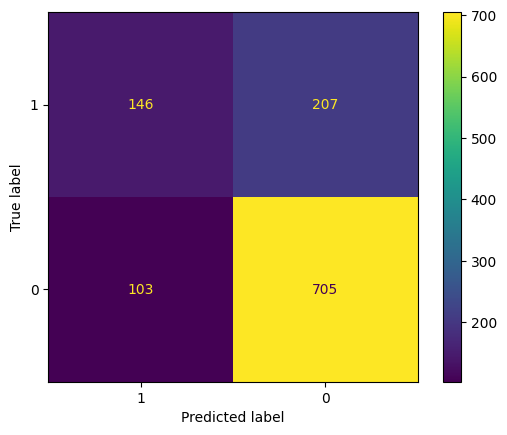

  Confusion matrix of testing preprocessing data using FuzzyWuzzy


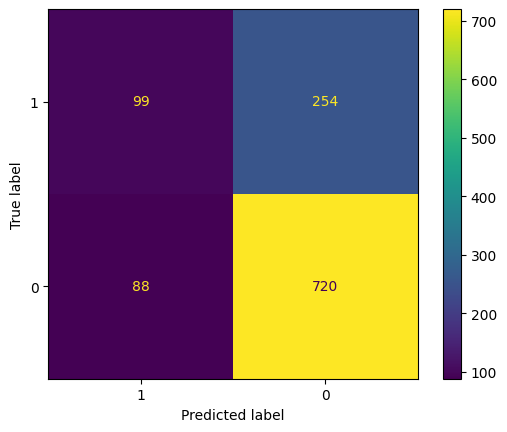

In [7]:
cm = confusion_matrix(y_test.to_numpy(), ytest_pred_fuzz)
cmd = ConfusionMatrixDisplay(cm, display_labels=['1','0'])
print('\033[1m' + '  Confusion matrix of testing original data using FuzzyWuzzy' + '\033[0m')
cmd.plot()
plt.show()

cm = confusion_matrix(y_test.to_numpy(), ytest_pred_fuzz2)
cmd = ConfusionMatrixDisplay(cm, display_labels=['1','0'])
print('\033[1m' + '  Confusion matrix of testing preprocessing data using FuzzyWuzzy' + '\033[0m')
cmd.plot()
plt.show()

# 4)	Calculate the sentence-to-sentence similarity measure using the Wu and Palma semantic similarity on data before preprocessing 

In [8]:
# Source code for task 4: https://nlpforhackers.io/wordnet-sentence-similarity/ 
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet as wn
 
def penn_to_wn(tag):
    """ Convert between a Penn Treebank tag to a simplified Wordnet tag """
    if tag.startswith('N'):
        return 'n'
 
    if tag.startswith('V'):
        return 'v'
 
    if tag.startswith('J'):
        return 'a'
 
    if tag.startswith('R'):
        return 'r'
 
    return None
 
def tagged_to_synset(word, tag):
    wn_tag = penn_to_wn(tag)
    if wn_tag is None:
        return None
 
    try:
        return wn.synsets(word, wn_tag)[0]
    except:
        return None
    
def sentence_similarity(sentence1, sentence2):
    """ compute the sentence similarity using Wordnet """
    # Tokenize and tag
    sentence1 = pos_tag(word_tokenize(sentence1))
    sentence2 = pos_tag(word_tokenize(sentence2))
 
    # Get the synsets for the tagged words
    synsets1 = [tagged_to_synset(*tagged_word) for tagged_word in sentence1]
    synsets2 = [tagged_to_synset(*tagged_word) for tagged_word in sentence2]
 
    # Filter out the Nones
    synsets1 = [ss for ss in synsets1 if ss]
    synsets2 = [ss for ss in synsets2 if ss]
 
    score, count = 0.0, 1
 
    # For each word in the first sentence
    for synset in synsets1:
        # Get the similarity value of the most similar word in the other sentence
        best_score = max([synset.path_similarity(ss) for ss in synsets2])
 
        # Check that the similarity could have been computed
        if best_score is not None:
            score += best_score
            count += 1
 
    # Average the values
    score /= count
    return score
 
def symmetric_sentence_similarity(sentence1, sentence2):
    """ compute the symmetric sentence similarity using Wordnet """
    return (sentence_similarity(sentence1, sentence2) + sentence_similarity(sentence2, sentence1)) / 2 

X_train_score['wup_score'] = X_train_score.apply(lambda row: symmetric_sentence_similarity(row['#1 String'], row['#2 String']), axis=1)
X_test_score['wup_score'] = X_test_score.apply(lambda row: symmetric_sentence_similarity(row['#1 String'], row['#2 String']), axis=1)

# Display some rows of training data and testing data
display_side_by_side([X_train_score.head(5), X_test_score.head(5)], ['Wu & Palma score of training MRPC Data', 'Wu & Palma score of testing MRPC Data'])

,Quality,#1 ID,#2 ID,#1 String,#2 String,fuzz_score,wup_score
3265,0,2760410,2760324,"Excluding the impact of accounting changes, Ford would have earned 13 cents a share.","Excluding the $56 million charge and the accounting change, Ford's third-quarter earnings amounted to 15 cents a share.",68,0.671726
2859,1,698940,698952,"Martha Stewart shares fell $2.03, about 18 percent, to $9.17 and were the NYSE's biggest percentage loser.","Its shares fell 4.6 percent, or $4.04, to $83.38 and was the blue-chip Dow's biggest percent loser.",64,0.751022
4692,1,2706235,2706274,"Jail warden Gene Fischi said said Selenski and Bolton broke their 12-inch-by-18-inch cell window, threw a mattress to the ground and shimmied down the rope to a second-story roof.","Warden Gene Fischi said the two inmates broke a 12-by-18-inch cell window, threw a mattress to the ground, and clambered down the makeshift rope to a second-story roof.",80,0.774693
5694,1,364462,364510,U.S. prosecutors have arrested more than 130 individuals and have seized more than $17 million in a continuing crackdown on Internet fraud and abuse.,More than 130 people have been arrested and $17 million worth of property seized in an Internet fraud sweep announced Friday by three U.S. government agencies.,49,0.576614
3105,1,327456,327366,Economists said that raised the odds of a rate cut at the Fed's next meeting on June 24-25.,Economists said those concerns raised the odds that the Fed might reduce rates at its next meeting on June 24-25.,75,0.724949
,Quality,#1 ID,#2 ID,#1 String,#2 String,fuzz_score,wup_score
3737,1,1621176,1621114,It is publishing the studies in the July issue of its Journal of Allergy and Clinical Immunology.,The reports are among several published this week in the Journal of Allergy and Clinical Immunology.,68,0.621759
1103,0,516006,515989,"Responding later, Edward Skyler, a spokesman for the mayor, said, ""The comptroller's statements, while noteworthy for their sensationalism, bear no relation to the facts.","Jordan Barowitz, a spokesman for Republican Mayor Michael Bloomberg said: ""The Comptroller's statements, while noteworthy for their sensationalism, bear no relation to the facts.""",80,0.754167
812,0,2128530,2128455,"However, EPA officials would not confirm the 20 percent figure.",Only in the past few weeks have officials settled on the 20 percent figure.,62,0.488125
1632,1,987465,987205,"However, George Heath, a Fort Campbell spokesman, said shortly after the attack that Akbar had ""an attitude problem"".","However, a Fort Campbell spokesman, said that Akbar had ""an attitude problem.""",79,0.778419


## Use logistic regression for estimate threshold and calculate accuracy score

In [9]:
# Estimate threshold, y, accuracy using logistic regression
_, _, ytest_pred_wup, threshold_wup, accuracy_wup = lr_threshold(X_train_score, y_train, X_test_score, y_test, 'wup_score')

# Perform model on the testing  data using logistic regression threshold
print('Wu & Palma accuracy score on testing samples:', round(accuracy_wup,3),'using estimate threshold =', round(threshold_wup,3))

Wu & Palma accuracy score on testing samples: 0.752 using estimate threshold = 0.544


## Confusion matrix of testing original data using FuzzyWuzzy and Wu - Palma¶

  Confusion matrix of testing original data using FuzzyWuzzy


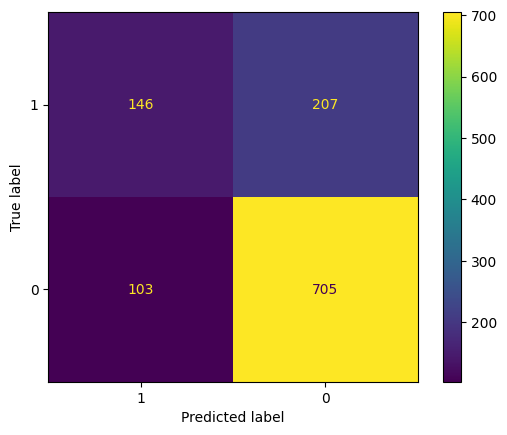

  Confusion matrix of testing original data using Wu & Palma


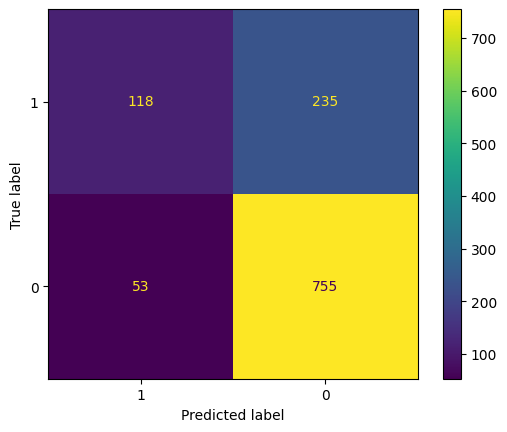

In [10]:
cm = confusion_matrix(y_test.to_numpy(), ytest_pred_fuzz)
cmd = ConfusionMatrixDisplay(cm, display_labels=['1','0'])
print('\033[1m' + '  Confusion matrix of testing original data using FuzzyWuzzy' + '\033[0m')
cmd.plot()
plt.show()

cm = confusion_matrix(y_test.to_numpy(), ytest_pred_wup)
cmd = ConfusionMatrixDisplay(cm, display_labels=['1','0'])
print('\033[1m' + '  Confusion matrix of testing original data using Wu & Palma' + '\033[0m')
cmd.plot()
plt.show()

# 5) Use pretrained FastText embedding word vectors to generate the embedding vector of each sentence, and then use cosine similarity to estimate the similarity between the two sentences. 

In [11]:
import fasttext 
import fasttext.util
from scipy.spatial.distance import cosine
#from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity(embedding_1, embedding_2):
    #Calculate the cosine similarity of the two embeddings.
    sim = 1 - cosine(embedding_1, embedding_2)
    return sim

#fasttext.util.download_model('en', if_exists='ignore')

ft = fasttext.load_model('cc.en.300.bin')

X_train_ft = X_train.copy()
X_test_ft = X_test.copy()

# Get sentence vector
X_train_ft['#1 String'] = X_train_ft['#1 String'].apply(ft.get_sentence_vector)
X_train_ft['#2 String'] = X_train_ft['#2 String'].apply(ft.get_sentence_vector)

X_test_ft['#1 String'] = X_test_ft['#1 String'].apply(ft.get_sentence_vector)
X_test_ft['#2 String'] = X_test_ft['#2 String'].apply(ft.get_sentence_vector)

X_train_ft['cosine_score'] = X_train_ft.apply(lambda row: cosine_similarity(row['#1 String'], row['#2 String']), axis=1)
X_test_ft['cosine_score'] = X_test_ft.apply(lambda row: cosine_similarity(row['#1 String'], row['#2 String']), axis=1)

# Display some rows of training data and testing data
#display_side_by_side([X_train_ft.head(1), X_test_ft.head(1)], ['Cosine similarity score of training MRPC Data', 'Cosine similarity score of testing MRPC Data'])

## Use logistic regression for estimate threshold and calculate accuracy score

In [12]:
# Estimate threshold, y, accuracy using logistic regression
_, _, ytest_pred_cos, threshold_cos, accuracy_cos = lr_threshold(X_train_ft, y_train, X_test_ft, y_test, 'cosine_score')

# Perform model on the testing  data using logistic regression threshold
print('Cosine similarity accuracy score using FastText on testing samples:', round(accuracy_cos,3),'using estimate threshold =', round(threshold_cos,3))

Cosine similarity accuracy score using FastText on testing samples: 0.73 using estimate threshold = 0.821


# 6) Repeat 5) when using BERT embedding 

In [15]:
from sentence_transformers import SentenceTransformer
#from .autonotebook import tqdm as notebook_tqdm
model = SentenceTransformer('all-MiniLM-L6-v2')

# Create copy
X_train_bert = X_train.copy()
X_test_bert = X_test.copy()

# Apply sentences BERT embdedding on data
X_train_bert['#1 String'] = X_train_bert['#1 String'].apply(model.encode)
X_train_bert['#2 String'] = X_train_bert['#2 String'].apply(model.encode)

X_test_bert['#1 String'] = X_test_bert['#1 String'].apply(model.encode)
X_test_bert['#2 String'] = X_test_bert['#2 String'].apply(model.encode)

# Use cosine similarity to estimate the similarity between the two sentences.
X_train_bert['cosine_score'] = X_train_bert.apply(lambda row: cosine_similarity(row['#1 String'], row['#2 String']), axis=1)
X_test_bert['cosine_score'] = X_test_bert.apply(lambda row: cosine_similarity(row['#1 String'], row['#2 String']), axis=1)

## Use logistic regression for estimate threshold and calculate accuracy score

In [16]:
# Estimate threshold, y, accuracy using logistic regression
_, _, ytest_pred_cos2, threshold_cos2, accuracy_cos2 = lr_threshold(X_train_bert, y_train, X_test_bert, y_test, 'cosine_score')

# Perform model on the testing  data using logistic regression threshold
print('Cosine similarity accuracy score using BERT on testing samples:', round(accuracy_cos2,3),'using estimate threshold =', round(threshold_cos2,3))

Cosine similarity accuracy score using BERT on testing samples: 0.75 using estimate threshold = 0.665


## Confusion matrix of testing original data using FastText and BERT

    Confusion matrix of testing original data using FastText


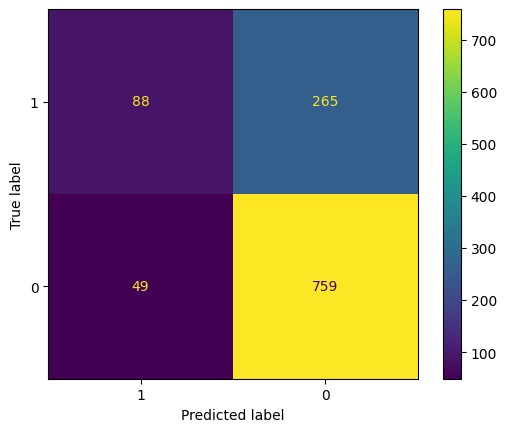

     Confusion matrix of testing original data using BERT


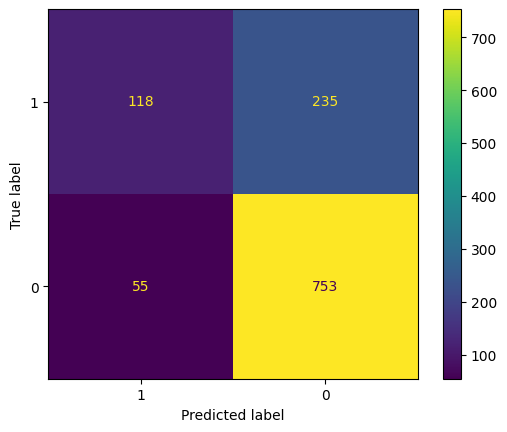

In [17]:
cm = confusion_matrix(y_test.to_numpy(), ytest_pred_cos)
cmd = ConfusionMatrixDisplay(cm, display_labels=['1','0'])
print('\033[1m' + '    Confusion matrix of testing original data using FastText' + '\033[0m')
cmd.plot()
plt.show()

cm = confusion_matrix(y_test.to_numpy(), ytest_pred_cos2)
cmd = ConfusionMatrixDisplay(cm, display_labels=['1','0'])
print('\033[1m' + '     Confusion matrix of testing original data using BERT' + '\033[0m')
cmd.plot()
plt.show()

# 7) Use Tf-Idf for feature space, Support Vector Machine as a classifier in order to use the existing labelling and estimate the accuracy on the testing dataset

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.compose import ColumnTransformer

# Create copy
X_train_tf = X_train.copy()
X_test_tf = X_test.copy()

# Declare tf-idf vector
vectorizer1 = TfidfVectorizer()
vectorizer2 = TfidfVectorizer()

# Create 2 features data using string 1 and 2
xtrain = X_train_tf[['#1 String','#2 String']]
xtest = X_test_tf[['#1 String','#2 String']]
# Construct the column transfomer
column_transformer = ColumnTransformer(
    [('tfidf1', vectorizer1, '#1 String'), 
    ('tfidf2', vectorizer2, '#2 String')],
    remainder='passthrough')

# Fit the model
clf = svm.SVC()
pipe = Pipeline([
                  ('tfidf', column_transformer),
                  ('classify', clf)
                ])
pipe.fit(xtrain, y_train.to_numpy())
ytest_pred_tf = pipe.predict(xtest)
print('Tf-idf feature accuracy score using SVM:', round(accuracy_score(ytest_pred_tf, y_test.to_numpy()),3))

Tf-idf feature accuracy score using SVM: 0.725
